<a href="https://colab.research.google.com/github/MayXiao/UvA_Thesis/blob/main/Thesis_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personal Information
Name: **Mengchen Xiao**

StudentID: **14257505**

Email: [**may.xiao@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **19.03.2023**

# Data Context
The dataset used in this project is [Visual Language Research Corpus](https://www.visuallanguagelab.com/tintin) of TINTIN Project. The Visual Language Research Corpus (VLRC) is a corpus of annotated comics analyzing the structures in visual languages of the world. The VLRC is made up of ~36,000 coded panels from 300+ comics from Europe, Asia, and the United States, across time periods (1940-present), and various genres.

# Data Description

Dataset constains 1 comic information csv file and 468 comics folders which are total 7811 images, and 66 countries of authors in the dataset. Average 17 images in each comic folder. The top 3 number of comics are from Bangladesh, Japan and Zimbabwe, while 10 countries have only comic book. The majority of comics are published after 2000 especially after 2010. 

There are 3 channels in all images, and total 5684 colorful and 2127 grey (black & white) images in this dataset. Sizes are varied (1320 sizes), for example ['1154 x 1666', '2083 x 2910', '883 x 1413']. Most image size are within 2500 x 3500, and many are around 1000 x 1500.

Color as an important feature of comic, contains location and period information, so to better capture it, no grayscale will be applied in the processing step. However, it's necessary to resize the images or randomly crop them to same size. 

For alternative dataset, this project will use [Manga109](https://paperswithcode.com/dataset/manga109) which composes of 109 manga volumes drawn by professional manga artists in Japan.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install seaborn==0.11.2
!pip install fuzzymatcher

In [2]:
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt    
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from torch.autograd import Variable
import fuzzymatcher
from fuzzymatcher import link_table, fuzzy_left_join

import random
import matplotlib.image as mpimg

from PIL import Image
import json

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Data Loading and preprocessing

In [3]:
path = '/content/drive/MyDrive/Thesis/TINTINCorpus_112622/'
df = pd.read_excel(path + 'TINTINCorpus_data_112622.xlsx') # loaded image information csv and created df
df.head()

,Project ID,Project Name,Document Name,Document Directory,Page Number,Region ID,Region Type,Region Vertices,Region Area,Annotation ID,...,Author origin,Author country,Global Region,Country,Language,Original Language,Genre,Style,Audience,Demographic:
0,12,TINTIN Project,Akira,5bad2589b5993964e2d64794507ddb30,3,2037,RECTANGLE,"(48,503), (197,701)",29502.0,3916,...,Japan,Japan,East Asia,Japan,English,Japanese,Sci-Fi,Manga,Teens/Adults,Seinen
1,12,TINTIN Project,Akira,5bad2589b5993964e2d64794507ddb30,3,2038,RECTANGLE,"(543,504), (993,701)",88650.0,3917,...,Japan,Japan,East Asia,Japan,English,Japanese,Sci-Fi,Manga,Teens/Adults,Seinen
2,12,TINTIN Project,Akira,5bad2589b5993964e2d64794507ddb30,3,2039,RECTANGLE,"(46,27), (993,488)",436567.0,3918,...,Japan,Japan,East Asia,Japan,English,Japanese,Sci-Fi,Manga,Teens/Adults,Seinen
3,12,TINTIN Project,Akira,5bad2589b5993964e2d64794507ddb30,3,2040,RECTANGLE,"(208,501), (500,701)",58400.0,3919,...,Japan,Japan,East Asia,Japan,English,Japanese,Sci-Fi,Manga,Teens/Adults,Seinen
4,12,TINTIN Project,Akira,5bad2589b5993964e2d64794507ddb30,3,2039,RECTANGLE,"(46,27), (993,488)",436567.0,4283,...,Japan,Japan,East Asia,Japan,English,Japanese,Sci-Fi,Manga,Teens/Adults,Seinen


In [4]:
my_folder = path + 'Exported images' 
sum(len(files) for _, _, files in os.walk(my_folder)) # check total number of images under all sub-folder 

7811

In [5]:
namel = list()
subfolder = list()

for root, dirs, files in os.walk(my_folder):
  for name in dirs:
    for root, dirs, files in os.walk(os.path.join(my_folder,name)):
      for filename in files:
          namel.append(filename)
          subfolder.append(root)

df1 = pd.DataFrame(zip(namel, subfolder), columns = ['name', 'subfolder']) # generated dataframe df1 which contains images' name and comics subfolder name
print(df1.head())

          name                                          subfolder
0  page-14.jpg  /content/drive/MyDrive/Thesis/TINTINCorpus_112...
1  page-16.jpg  /content/drive/MyDrive/Thesis/TINTINCorpus_112...
2  page-17.jpg  /content/drive/MyDrive/Thesis/TINTINCorpus_112...
3  page-15.jpg  /content/drive/MyDrive/Thesis/TINTINCorpus_112...
4  page-11.jpg  /content/drive/MyDrive/Thesis/TINTINCorpus_112...


In [6]:
col_list = ['Document Name','Global Region','Artist', 'Author country','Author origin','Publication Date',]
df_info = df[col_list].drop_duplicates()
df_info.rename({'Document Name': 'document_name'}, axis=1, inplace=True) # preprocess(subset&rename) comic information df
df1['subfolder_name'] = df1.subfolder.str.split('/', expand=True)[7]  # preprocess 

df_final = fuzzymatcher.link_table(df1, df_info, 'subfolder_name', 'document_name') # fuzzy join 2 tables using comic's names, since comic on both files are not exactly the same
df_final = df_final.reset_index(drop=True)

In [7]:
df_final.head()

,__id_left,__id_right,match_score,match_rank,subfolder_name,document_name
0,0_left,392_right,0.38491,1,Tokyo Ghoul,Tokyo Ghoul
1,1_left,392_right,0.38491,1,Tokyo Ghoul,Tokyo Ghoul
2,2_left,392_right,0.38491,1,Tokyo Ghoul,Tokyo Ghoul
3,3_left,392_right,0.38491,1,Tokyo Ghoul,Tokyo Ghoul
4,4_left,392_right,0.38491,1,Tokyo Ghoul,Tokyo Ghoul


In [8]:
df_final[df_final.match_rank == 1].shape

(7811, 6)

In [9]:
df_final1 = df_final[df_final.match_rank == 1] #fuzzy match creates multiple join, here only subset the top match result

In [10]:
fuzzy_match_pairs = df_final1[['subfolder_name','document_name']].drop_duplicates() 
fuzzy_match_pairs

,subfolder_name,document_name
0,Tokyo Ghoul,Tokyo Ghoul
17,Mein Hero-SOS Crew,Basila & The Street Crew 1
185,Quintstar - 48-Hour,Quintstar - 48-Hour
199,The Oysters of Time,The Oysters of Time
211,Emperor Doom,Emperor Doom
...,...,...
27452,Hemilios,Hemilios
27474,El Jefe,El Jefe
27484,Hujan di Tepian Rindu,Di Iche
27594,Turma da M--nica Jove- Terr--vel Obsess--o,Turma da M√¥nica Jove: Terr√≠vel Obsess√£o


In [11]:
df1_match = pd.merge(df1,fuzzy_match_pairs, left_on='subfolder_name', right_on='subfolder_name', how='left')

In [12]:
df1_info_fuzzy_match = pd.merge(df1_match,df_info, left_on='document_name', right_on='document_name', how='left')

In [13]:
df1_info_fuzzy_match['Publication Date'] = df1_info_fuzzy_match['Publication Date'].str.replace('1995-2001','2001') # replace string year value with int 
df1_info_fuzzy_match['Publication Date'] = df1_info_fuzzy_match['Publication Date'].astype(np.float).astype("Int32")

In [14]:
df1_info_fuzzy_match.head()

,name,subfolder,subfolder_name,document_name,Global Region,Artist,Author country,Author origin,Publication Date
0,page-14.jpg,/content/drive/MyDrive/Thesis/TINTINCorpus_112...,Tokyo Ghoul,Tokyo Ghoul,East Asia,Ishida Sui,Japan,Japan,2011
1,page-16.jpg,/content/drive/MyDrive/Thesis/TINTINCorpus_112...,Tokyo Ghoul,Tokyo Ghoul,East Asia,Ishida Sui,Japan,Japan,2011
2,page-17.jpg,/content/drive/MyDrive/Thesis/TINTINCorpus_112...,Tokyo Ghoul,Tokyo Ghoul,East Asia,Ishida Sui,Japan,Japan,2011
3,page-15.jpg,/content/drive/MyDrive/Thesis/TINTINCorpus_112...,Tokyo Ghoul,Tokyo Ghoul,East Asia,Ishida Sui,Japan,Japan,2011
4,page-11.jpg,/content/drive/MyDrive/Thesis/TINTINCorpus_112...,Tokyo Ghoul,Tokyo Ghoul,East Asia,Ishida Sui,Japan,Japan,2011


### Data analysis1:

In [15]:
print('There are {} comics, total {} images and {} countries of authors in the dataset.'.format(len(df1_info_fuzzy_match.subfolder_name.unique()), \
                                                                       len(df1_info_fuzzy_match),\
                                                                       len(df1_info_fuzzy_match['Author country'].unique())))

There are 468 comics, total 7811 images and 66 countries of authors in the dataset.


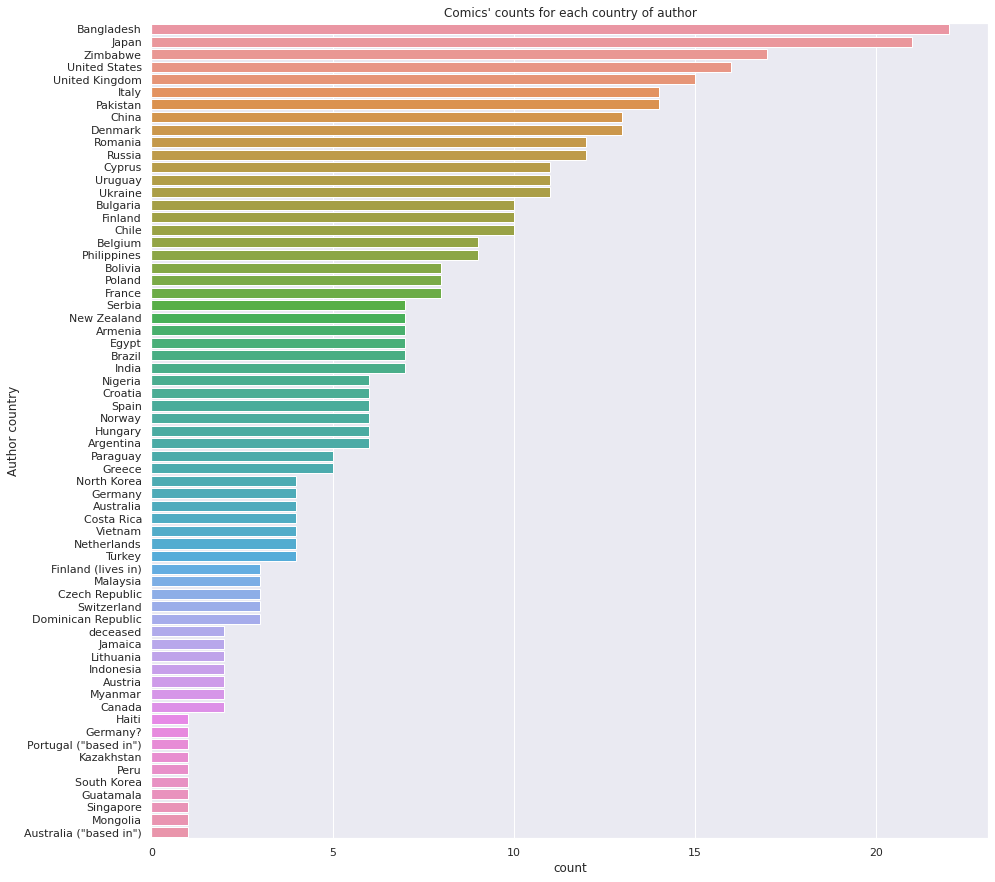

In [16]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.figsize":(15, 15)})
df1_info_fuzzy_match_author_country = df1_info_fuzzy_match[['Author country','subfolder_name']].drop_duplicates()

sns.countplot(y=df1_info_fuzzy_match_author_country['Author country']
              # ,order=pd.value_counts(df1_info_fuzzy_match['Author country']).iloc[:20].index)
              ,order = df1_info_fuzzy_match_author_country['Author country'].value_counts().index) 
plt.title("Comics' counts for each country of author")
plt.show()

Take a look at the where the author coming from and and what is the count distribution of authors, Top3 countries: Bangladesh, Japan, Zimbabwe. 10 countries have only comic book.

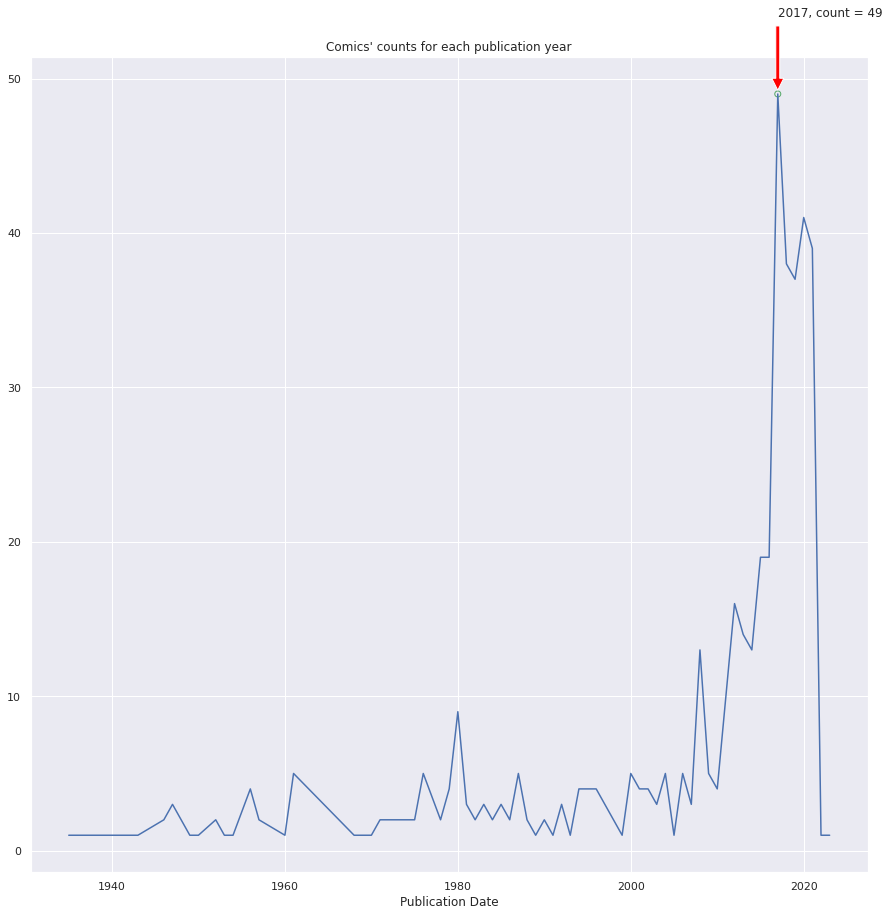

In [17]:
df1_info_fuzzy_match_publish_year = df1_info_fuzzy_match[['Publication Date','subfolder_name']].drop_duplicates()
df1_info_fuzzy_match_publish_year1 = df1_info_fuzzy_match_publish_year.groupby('Publication Date').size()
ymax = max(df1_info_fuzzy_match_publish_year1.values)
# ymin = min(df1_info_fuzzy_match_publish_year1.values)
ax = sns.lineplot(x=df1_info_fuzzy_match_publish_year1.index,y=np.array(df1_info_fuzzy_match_publish_year1.values, dtype=float))
for date_value, factor_value in df1_info_fuzzy_match_publish_year1[(df1_info_fuzzy_match_publish_year1 == ymax)].items():
    ax.scatter(date_value, factor_value, facecolors='none', edgecolors='g')
    text1 = "{:}, count = {:.0f}".format(date_value, factor_value)
    ax.annotate(text1, xy=(date_value, factor_value), xytext=(date_value, factor_value+5),
            arrowprops=dict(facecolor='red', shrink=0.05),
            ) 
plt.title("Comics' counts for each publication year")
plt.show()

As for publication date, the majority of comics are published after 2000 especially after 2010. There are 49 comics were published in 2017.

### Data analysis2:

Let's check what comic images look like: some are white and black, some are colorful. Sizes are varied differently

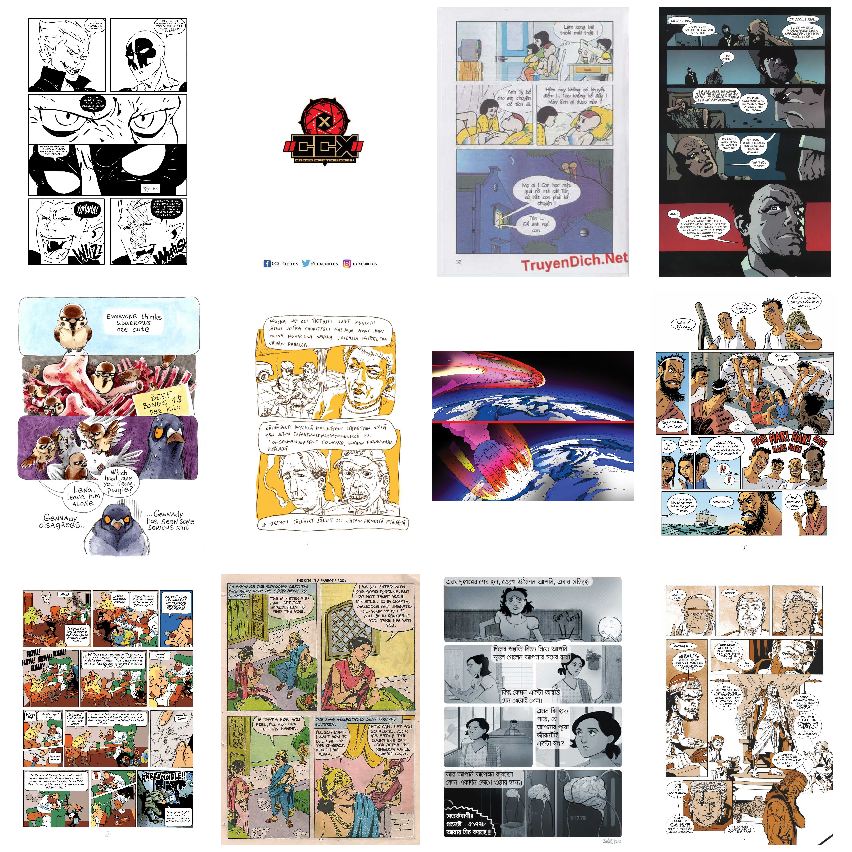

In [48]:
path = my_folder
subfolders = os.listdir(path)
random_subfolders = random.sample(subfolders, 12)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i, subfolder in enumerate(random_subfolders):
    images = os.listdir(os.path.join(path, subfolder))
    image = random.choice(images)
    img = mpimg.imread(os.path.join(path, subfolder, image))
    axs[i//4][i%4].imshow(img,interpolation='nearest')
    axs[i//4][i%4].axis('off')

plt.tight_layout()
plt.show()

To identify the number of black and white and colorful images repectively, we can calculate the sum differences between the green, blue, and red channels of an image, and then compare the ratio of these differences to a threshold value(0.005). If the ratio is below the threshold, the image is classified as black and white; otherwise, it is classified as colorful. Below are 2 examples to examinize the results.

In [19]:
import cv2
def bw_co(image_path):
  img=cv2.imread(image_path)
  r,g,b=cv2.split(img)
  #spliting b,g,r and getting differences between them
  r_g=np.count_nonzero(abs(r-g))
  r_b=np.count_nonzero(abs(r-b))
  g_b=np.count_nonzero(abs(g-b))
  diff_sum=float(r_g+r_b+g_b)
  #finding ratio of diff_sum with respect to size of image
  ratio=diff_sum/img.size
  if ratio>0.005:
      label='colorful.'
  else:
      label='grey (black & white).'
  return label

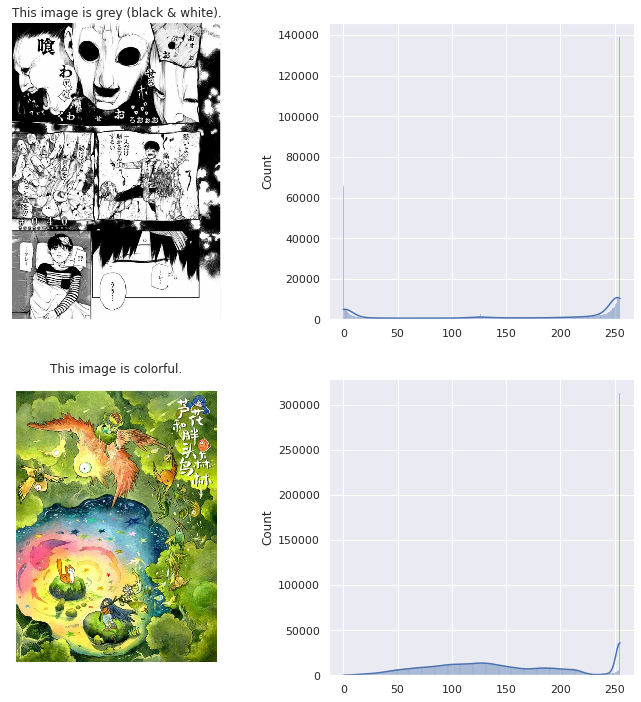

In [20]:
# example to check effectiveness of above method
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
image_path1 = my_folder + '/Tokyo Ghoul/page-2.jpg'
img = mpimg.imread(image_path1)
axs[0,0].imshow(img,interpolation='nearest')
axs[0,0].axis('off')
axs[0,0].title.set_text("This image is {}".format(bw_co(image_path1)))

im = cv2.imread(image_path1)
vals = im.mean(axis=2).flatten()
sns.histplot(vals, bins=255, kde=True, ax = axs[0,1])


image_path2 = my_folder + '/Raven Forest/page-1.jpg'
img = mpimg.imread(image_path2)
axs[1,0].imshow(img,interpolation='nearest')
axs[1,0].axis('off')
axs[1,0].title.set_text("This image is {}".format(bw_co(image_path2)))

im = cv2.imread(image_path2)
vals2 = im.mean(axis=2).flatten()
# plot histogram with 255 bins
sns.histplot(vals2, bins=255, kde=True, ax = axs[1,1])

plt.show() 

In [ ]:
from PIL import Image
import json
# Initialize a dictionary to store the folder sizes
img_sizes = []
cmc_sizes = {}
band = {}
pix = {}
pix_val = []
# Traverse through all the subdirectories and files within the root directory
for dirpath, dirnames, filenames in os.walk(my_folder):
    # if dirpath in ['/content/drive/MyDrive/Thesis/TINTINCorpus_112622/Exported images/Raven Forest']: # Tokyo Ghoul
    # if dirpath in ['/content/drive/MyDrive/Thesis/TINTINCorpus_112622/Exported images/Tokyo Ghoul']:
      # print(dirpath)
      for filename in filenames:
          if filename.endswith('.jpg'):
              image_path = os.path.join(dirpath, filename)

              pix_val.append(bw_co(image_path))
              pix[dirpath.split('/')[-1]] = pix_val
              # print(pix)

              with open('pix.json', 'w') as fp:
                json.dump(pix, fp)

              with Image.open(image_path) as img:
                width, height = img.size
                img_sizes.append((f"{width} x {height}"))  
                # Add the image size to the dictionary
                cmc_sizes[dirpath.split('/')[-1]] = img_sizes
                with open('cmc_sizes.json', 'w') as fp:
                  json.dump(cmc_sizes, fp)
                # Add the color channel to the dictionary                
                bands = img.getbands()
                band[dirpath.split('/')[-1]] = bands
                with open('band.json', 'w') as fp:
                  json.dump(band, fp)                

# print(pix)    
# Print the folder sizes
# print(folder_sizes)


In [21]:
path2 = '/content/drive/MyDrive/Thesis/'
with open(path2 + 'pix.json', 'rb') as f:
  data = json.load(f)

with open(path2 + 'cmc_sizes.json', 'rb') as f:
  data1 = json.load(f)

with open(path2 + 'band.json', 'rb') as f:
  data2 = json.load(f)

In [22]:
print('There are {} channels in all images.'.format(len(set(data2["Raven Forest"]))))
print('There are total {} colorful and {} grey (black & white) images in this dataset.'\
      .format(len([i for i in data["Raven Forest"] if i == 'colorful.']), len([i for i in data["Raven Forest"] if i == 'grey (black & white).'])) )
print('There are total {} different sizes images in this dataset, for example {}.'\
      .format(len(set(data1["Raven Forest"])), random.sample(set(data1["Raven Forest"]), 3)))

There are 3 channels in all images.
There are total 5684 colorful and 2127 grey (black & white) images in this dataset.
There are total 1320 different sizes images in this dataset, for example ['1639 x 2291', '1483 x 2091', '907 x 1321'].


In [33]:
df_sizes = pd.DataFrame([i.split(' x ') for i in data1["Raven Forest"]], columns = ['width', 'height'])
df_sizes['width'] = df_sizes['width'].astype('int')
df_sizes['height'] = df_sizes['height'].astype('int')

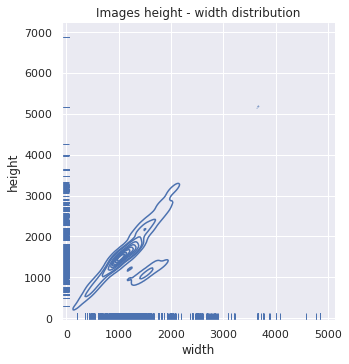

Most image size are within 2500 x 3500, and many are around 1000 x 1500.


In [47]:
sns.displot(data=df_sizes, x="width", y="height", kind="kde", rug=True)
plt.title('Images height - width distribution')
plt.show()
print('Most image size are within 2500 x 3500, and many are around 1000 x 1500.')